In [1]:
import os
import os.path
import numpy as np
import glob
import matplotlib.pyplot as plt
import preprocessing_functions as pre
import training_functions as training
import skimage.io
import prediction as pred
import keras


Using TensorFlow backend.


In [2]:
# load all images
images = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*d0.png") # define imagefolder
X_stack = pre.stack_images(images)
images = glob.glob(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\16bitImages\*d1.png") # define imagefolder
Y_stack= pre.stack_images(images)

In [3]:
# normalize images
(x_norm, mean, std) = pre.norm_batch(X_stack)
y_norm = pre.norm(Y_stack, mean, std)

In [4]:
x_norm.shape

(52, 1104, 1104)

In [5]:
# define images for training (change to automated later)
X_train = x_norm[0:40]
Y_train = y_norm[0:40]
X_val = x_norm[40:53]
Y_val = y_norm[40:53]

In [6]:
# train UNet
history = training.train(X_train, Y_train, X_val, Y_val, 'mdl_16bit_d1')



Input (None, 128, 128, 1)
1. Conv (None, 64, 64, 64)
2. conv (None, 64, 64, 128)
3. conv (None, 32, 32, 256)
4. conv (None, 16, 16, 512)
1. UpConv (None, 32, 32, 768)
2. UpConv (None, 64, 64, 384)
3. UpConv (None, 128, 128, 192)
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 64) 640         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 64) 256         conv2d[0][0]                     
______________________________________________________________

Epoch 1/15
10/10 [==============================] - 40s 4s/step - loss: 1.6329 - mse: 1.6329 - mae: 0.8151 - val_loss: 2.3702 - val_mse: 2.3702 - val_mae: 0.8548
Epoch 2/15
10/10 [==============================] - 37s 4s/step - loss: 0.7393 - mse: 0.7393 - mae: 0.5749 - val_loss: 0.4905 - val_mse: 0.4905 - val_mae: 0.4754
Epoch 3/15
10/10 [==============================] - 38s 4s/step - loss: 0.8672 - mse: 0.8672 - mae: 0.6153 - val_loss: 0.6384 - val_mse: 0.6384 - val_mae: 0.5485
Epoch 4/15
10/10 [==============================] - 39s 4s/step - loss: 0.7847 - mse: 0.7847 - mae: 0.5908 - val_loss: 0.4296 - val_mse: 0.4296 - val_mae: 0.5401
Epoch 5/15
10/10 [==============================] - 38s 4s/step - loss: 0.9002 - mse: 0.9002 - mae: 0.6064 - val_loss: 1.0770 - val_mse: 1.0770 - val_mae: 0.7790
Epoch 6/15
10/10 [==============================] - 38s 4s/step - loss: 0.8536 - mse: 0.8536 - mae: 0.6234 - val_loss: 0.4447 - val_mse: 0.4447 - val_mae: 0.5159
Epoch 7/15
10/10 [==========

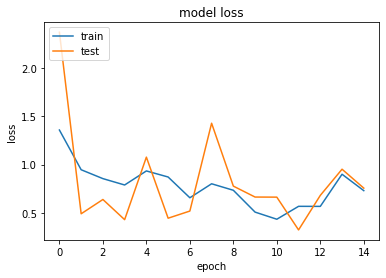

In [7]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [8]:
out = []
model = keras.models.load_model('mdl_16bit_d1')
for n in range(5):
    image = X_val[n]

    output = pred.predict(model, image, 128, 128, num_outputs=1)
    output_norm = pre.unnormalize(output, mean, std)
    out.append(output_norm)
out = np.stack(out, axis = 0)

(144, 128, 128, 1)
(144, 128, 128, 1)
(144, 128, 128, 1)
(144, 128, 128, 1)
(144, 128, 128, 1)


In [9]:
im = out[1]
skimage.io.imsave(r"C:\Users\tsche\Desktop\Master\2. Semester\Project Staining\pred_im\test3.png", im)

Lossy conversion from float64 to uint8. Range [3672.9609963528287, 45247.205105878464]. Convert image to uint8 prior to saving to suppress this warning.


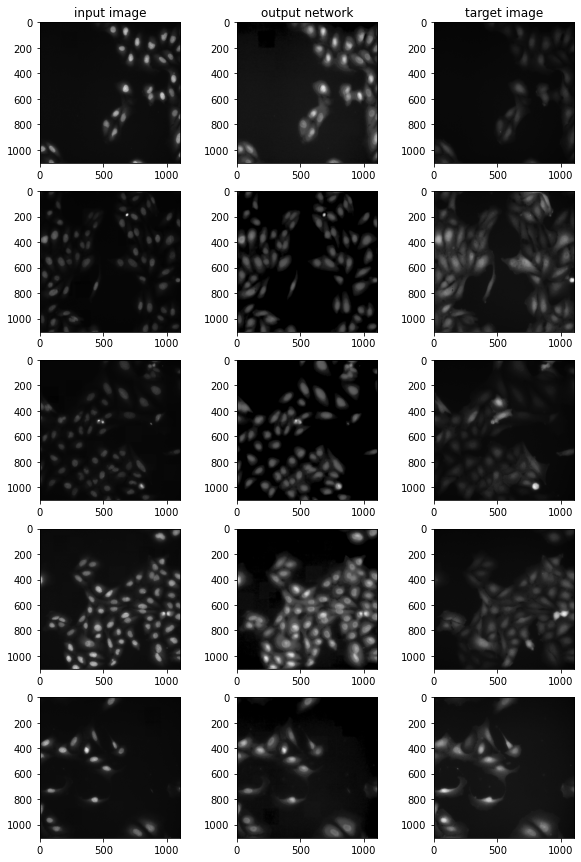

In [10]:
plt.figure(figsize=(10,15)) 

for p in range(5):
    plt.subplot(5,3,1+3*p)    
    plt.imshow(X_val[p], cmap='gray')
    if p == 0:
        plt.title('input image')

    plt.subplot(5,3,2+3*p)    
    plt.imshow(out[p], cmap='gray')
    if p == 0:
        plt.title('output network')

    plt.subplot(5,3,3+3*p) 
    plt.imshow(Y_val[p], cmap='gray')
    if p == 0:
        plt.title('target image')

plt.show()

